# Regional Bias

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
from warnings import warn

import cf_xarray as cfxr
import cordex as cx
import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regionmask
import xarray as xr
import xesmf as xe
from dask.distributed import Client
from evaltools import obs
from evaltools.obs import eobs_mapping
from evaltools.source import get_source_collection, open_and_sort
from evaltools.utils import short_iid

# from evaltools.eval import regional_means


dask.config.set(scheduler="single-threaded")

In [3]:
def traverseDir(root):
    for dirpath, dirnames, filenames in os.walk(root):
        for file in filenames:
            if file.endswith(".nc"):
                yield os.path.join(dirpath, file)

In [4]:
def regional_mean(ds, regions=None, weights=None, aggr=None):
    """
    Compute the regional mean of a dataset over specified regions.

    Parameters:
    ds (xarray.Dataset): The dataset to compute the regional mean for.
    regions (regionmask.Regions): The regions to compute the mean over.

    Returns:
    xarray.Dataset: The regional mean values.
    """
    mask = 1.0
    if weights is None:
        weights = xr.ones_like(ds.lon)
    if regions:
        mask = regions.mask_3D(ds.lon, ds.lat, drop=False)
    if aggr == "mean":
        result = ds.cf.weighted(mask * weights).mean(dim=("X", "Y"), skipna=True)
    elif aggr == "P95":
        ds = np.abs(ds)
        ds = ds.where(mask)
        result = ds.cf.quantile(0.95, dim=["X", "Y"], skipna=True)

    return result


def regional_means(dsets, regions=None, aggr=None):
    """
    Compute the regional means for multiple datasets over specified regions.

    Parameters:
    dsets (dict): A dictionary of datasets to compute the regional means for.
    regions (regionmask.Regions): The regions to compute the means over.

    Returns:
    xarray.Dataset: The concatenated regional mean values for all datasets.
    """
    concat_dim = xr.DataArray(list(dsets.keys()), dims="iid", name="iid")
    return xr.concat(
        [regional_mean(ds, regions, None, aggr) for ds in dsets.values()],
        dim=concat_dim,
        coords="minimal",
        compat="override",
    )

In [5]:
client = Client(dashboard_address="localhost:8787", threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 125.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43401,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 125.79 GiB
Comm: tcp://127.0.0.1:35569,Total threads: 1
Dashboard: http://127.0.0.1:44299/status,Memory: 7.86 GiB
Nanny: tcp://127.0.0.1:43783,


In [6]:
vertices = {
    "CMIP6": ("vertices_lon", "vertices_lat"),
    "CMIP5": ("lon_vertices", "lat_vertices"),
}


def add_bounds(ds):
    if "longitude" not in ds.cf.bounds and "latitude" not in ds.cf.bounds:
        ds = cx.transform_bounds(ds, trg_dims=("vertices_lon", "vertices_lat"))
    lon_bounds = ds.cf.get_bounds("longitude")
    lat_bounds = ds.cf.get_bounds("latitude")
    bounds_dim = [dim for dim in lon_bounds.dims if dim not in ds.indexes][0]
    # reshape bounds for xesmf
    ds = ds.assign_coords(
        lon_b=cfxr.bounds_to_vertices(
            lon_bounds, bounds_dim=bounds_dim, order="counterclockwise"
        ),
        lat_b=cfxr.bounds_to_vertices(
            lat_bounds, bounds_dim=bounds_dim, order="counterclockwise"
        ),
    )
    return ds


def mask_with_sftlf(ds, sftlf=None):
    if sftlf is None and "sftlf" in ds:
        sftlf = ds["sftlf"]
        for var in ds.data_vars:
            if var != "sftlf":
                ds[var] = ds[var].where(sftlf > 0)
        ds["mask"] = sftlf > 0
    else:
        warn(f"sftlf not found in dataset: {ds.source_id}")
    return ds


def open_datasets(
    variables, frequency="mon", mask=True, add_missing_bounds=True, **kwargs
):
    cat = get_source_collection(
        variables, frequency, add_fx=["areacella", "sftlf"], **kwargs
    )
    dsets = open_and_sort(cat, merge_fx=True, apply_fixes=True)
    if mask is True:
        for ds in dsets.values():
            mask_with_sftlf(ds)
    if add_missing_bounds is True:
        for dset_id, ds in dsets.items():
            dsets[dset_id] = add_bounds(ds)
    return dsets


def create_cordex_grid(domain_id, **kwargs):
    grid = cx.domain(domain_id, bounds=True, **kwargs)
    # grid["lon"].attrs = {}
    # grid["vertices_lat"].attrs = {}
    lon_b = cfxr.bounds_to_vertices(
        grid.cf.get_bounds("lon"), bounds_dim="vertices", order="counterclockwise"
    )
    lat_b = cfxr.bounds_to_vertices(
        grid.cf.get_bounds("lat"), bounds_dim="vertices", order="counterclockwise"
    )
    return grid.assign_coords(lon_b=lon_b, lat_b=lat_b)


def create_regridder(source, target, method="bilinear"):
    regridder = xe.Regridder(source, target, method=method)
    return regridder


def regrid(ds, regridder):
    ds_regrid = regridder(ds)
    for var in ds.data_vars:
        if var not in ["mask", "sftlf"]:
            ds_regrid[var] = ds_regrid[var].where(ds_regrid["mask"] > 0.0)
    return ds_regrid


def regrid_dsets(dsets, target_grid, method="bilinear"):
    for dset_id, ds in dsets.items():
        print(dset_id)
        mapping = ds.cf["grid_mapping"].grid_mapping_name
        if mapping == "rotated_latitude_longitude":
            dsets[dset_id] = ds.cx.rewrite_coords(coords="all")
        else:
            print(f"regridding {dset_id} with grid_mapping: {mapping}")
            regridder = create_regridder(ds, target_grid, method=method)
            print(regridder)
            dsets[dset_id] = regrid(ds, regridder)
    return dsets


def mask_invalid(ds, vars=None, threshold=0.1):
    if isinstance(vars, str):
        vars = [vars]
    if vars is None:
        var = list(ds.data_vars)
    for var in vars:
        var_nan = ds[var].isnull().sum(dim="time") / ds.time.size
        ds[var] = ds[var].where(var_nan < threshold)
    return ds

In [7]:
def standardize_unit(ds, variable):
    if variable == "tas":
        ds = convert_celsius_to_kelvin(ds)
    elif variable == "pr":
        ds = convert_precipitation_to_mm(ds)
    return ds


def convert_celsius_to_kelvin(ds, threshold=200):
    """
    Converts all temperature variables in an xarray Dataset from degrees Celsius to Kelvin
    based on the 'units' attribute, value magnitude, or 'standard_name' attribute.

    Parameters:
        ds (xarray.Dataset): The input dataset.
        threshold (float): A heuristic threshold (default=200) to assume temperatures
                           below this value might be in Celsius.

    Returns:
        xarray.Dataset: A new dataset with converted temperature values.
    """
    ds = ds.copy()  # Avoid modifying the original dataset

    for var in ds.data_vars:
        units = ds[var].attrs.get("units", "").lower()
        standard_name = ds[var].attrs.get("standard_name", "").lower()

        # Check if units explicitly indicate Celsius
        if units in ["c", "°c", "celsius", "degc"]:
            ds[var] = ds[var] + 273.15
            ds[var].attrs["units"] = "K"
            print("Convert celsius to kelvin")

        # If no unit attribute exists, check standard_name for temperature-related terms
        elif standard_name in [
            "air_temperature",
            "sea_surface_temperature",
            "surface_temperature",
        ]:
            data_vals = ds[var].values
            if np.nanmax(data_vals) < threshold:  # Likely in °C
                ds[var] = ds[var] + 273.15
                ds[var].attrs["units"] = "K"
                print("Convert celsius to kelvin")

    return ds


def convert_precipitation_to_mm(ds):
    """
    Converts all precipitation variables in an xarray Dataset to millimeters (mm)
    based on the 'units' attribute or 'standard_name' attribute.

    Parameters:
        ds (xarray.Dataset): The input dataset.

    Returns:
        xarray.Dataset: A new dataset with converted precipitation values.
    """
    ds = ds.copy()  # Avoid modifying the original dataset

    for var in ds.data_vars:
        units = ds[var].attrs.get("units", "").lower()
        # standard_name = ds[var].attrs.get("standard_name", "").lower()

        # Check if units explicitly indicate meters (m) or kilograms per meter per second squared (kg/m/s²)
        if units in ["m", "meters"]:
            ds[var] = ds[var] * 1000  # Convert from meters to millimeters
            ds[var].attrs["units"] = "mm"
            print("Convert precipitation from meters to millimeters (mm).")

        elif units in ["kg m-2 s-1", "kg/m/s2"]:
            # Precipitation rate in kg/m/s² can be converted to mm/s by multiplying by 1000
            ds[var] = ds[var] * 86400  # Convert kg/m/s² to mm/s
            ds[var].attrs["units"] = "mm"
            print("Convert precipitation from kg/m/s² to mm/s.")

    return ds

In [8]:
def seasonal_mean(da):
    """Optimized function to calculate seasonal averages from time series of monthly means

    based on: https://xarray.pydata.org/en/stable/examples/monthly-means.html
    """
    # Get number od days for each month
    month_length = da.time.dt.days_in_month
    # Calculate the weights by grouping by 'time.season'.
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    # np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (
        (da * weights).groupby("time.season").sum(dim="time", skipna=True, min_count=1)
    )

In [9]:
def check_equal_period(ds, period):
    years_in_ds = np.unique(ds.time.dt.year.values)
    expected_years = np.arange(int(period.start), int(period.stop) + 1)
    return np.array_equal(years_in_ds, expected_years)

In [10]:
def fix_360_longitudes(dataset: xr.Dataset, lonname: str = "lon") -> xr.Dataset:
    """
    Fix longitude values.

    Function to transform datasets where longitudes are in (0, 360) to (-180, 180).

    Parameters
    ----------
    dataset (xarray.Dataset): data stored by dimensions
    lonname (str): name of the longitude dimension

    Returns
    -------
    dataset (xarray.Dataset): data with the new longitudes
    """
    lon = dataset[lonname]
    if lon.max().values > 180 and lon.min().values >= 0:
        dataset[lonname] = dataset[lonname].where(lon <= 180, other=lon - 360)
    return dataset

In [11]:
default_attrs_ = [
    "project_id",
    "domain_id",
    "institution_id",
    "driving_source_id",
    "driving_experiment_id",
    "driving_variant_label",
    "source_id",
    "version_realization",
    "frequency",
    "variable_id",
    "version",
]

In [12]:
var_dic = {
    "tas": {
        "variable": "tas",
        "name": "Temperature BIAS [K]",
        "diff": "abs",
        "range": [-4, 4],
        "aggr": "mean",
        "datasets": ["era5", "cerra"],
    },
    "pr": {
        "variable": "pr",
        "name": "Precipitation BIAS [%]",
        "diff": "rel",
        "range": [-60, 180],
        "aggr": "mean",
        "datasets": ["era5", "cerra-land"],
    },
    "tas95": {
        "variable": "tas",
        "name": "Temperature 95%-P [K]",
        "diff": "abs",
        "range": [-2, 10],
        "aggr": "P95",
        "datasets": ["era5", "cerra"],
    },
    "pr95": {
        "variable": "pr",
        "name": "Precipitation 95%-P [%]",
        "diff": "rel",
        "range": [0, 400],
        "aggr": "P95",
        "datasets": ["era5", "cerra-land"],
    },
}

In [13]:
# Parameter papermill
index = "pr"
frequency = "mon"
domain = "EUR-11"
regridding = "bilinear"
period = slice("1989", "2008")
reference_regions = "PRUDENCE"

In [14]:
save_results_path = os.path.abspath(
    os.path.join(os.getcwd(), "..", "intermediate-results")
)
save_figure_path = os.path.abspath(os.path.join(os.getcwd(), "..", "plots"))

In [15]:
variable = var_dic[index]["variable"]

In [16]:
eur_colors = pd.read_csv("eurocordex_models.csv")

In [17]:
# prudence
regions = regionmask.defined_regions.prudence

In [18]:
rotated_grid = create_cordex_grid("EUR-11", mip_era="CMIP5")  # No matter CMIP5 or CMIP6

## E-OBS is used as the reference dataset for all the analysis
It is used to calculate bias not only respect to CORDEX, but also in comparison wit other reanalyses and observational dataset, to assess the uncertaintly of the observational dataset

In [19]:
# load, regrid and calculate seasonal means
eobs_var = [key for key, value in eobs_mapping.items() if value == variable][0]
eobs = obs.eobs(variables=eobs_var, add_mask=False).sel(time=period)
eobs = mask_invalid(eobs, vars=eobs_var, threshold=0.1)
eobs = standardize_unit(eobs, variable)
# eobs = load_eobs(add_mask=False, to_cf=False, variable = variable)
# unmapped_to_nan, see https://github.com/pangeo-data/xESMF/issues/56
regridder = xe.Regridder(eobs, rotated_grid, method=regridding, unmapped_to_nan=True)
ref_on_rotated = regridder(eobs)
if not check_equal_period(ref_on_rotated, period):
    print(f"Temporal coverage of dataset does not match with {period}")
ref_seasmean = seasonal_mean(ref_on_rotated[eobs_var].sel(time=period)).compute()

/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 15.11 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


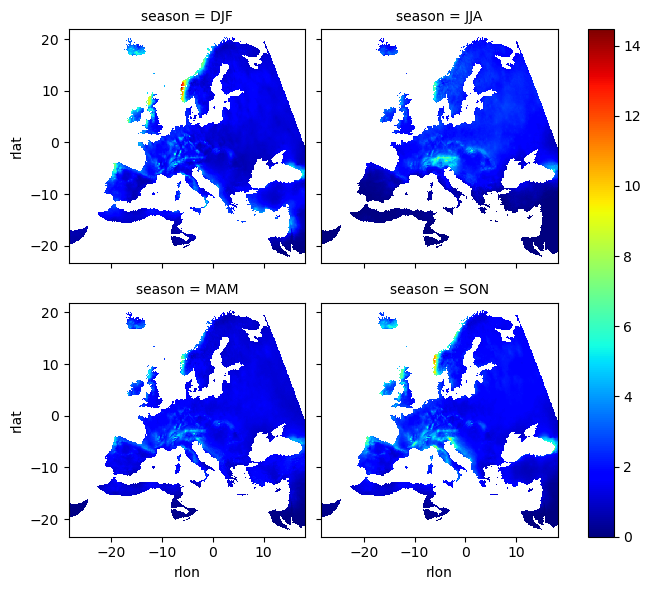

In [20]:
ref_seasmean.plot(col="season", col_wrap=2, cmap="jet")

## CERRA and ERA5

In [21]:
variable_mapping = {
    "cerra": {"tas": "t2m", "pr": "tp"},
    "cerra-land": {"tas": "tas", "pr": "tp"},
    "era5": {"tas": "t2m", "pr": "tp"},
}


def load_obs(variable, dataset, add_mask=False):
    root = f"/mnt/CORDEX_CMIP6_tmp/aux_data/{dataset}/mon/{variable}/"
    ds = xr.open_mfdataset(
        np.sort(list(traverseDir(root))), concat_dim="valid_time", combine="nested"
    )
    ds = ds.rename({"valid_time": "time"})
    return ds

In [22]:
dsets = {}
for dset in var_dic[variable]["datasets"]:
    ds = load_obs(variable, dset)
    ds = ds.sel(time=period).compute()
    ds = fix_360_longitudes(ds, lonname="longitude")
    if not variable_mapping[dset][variable] == variable:
        ds = ds.rename_vars({variable_mapping[dset][variable]: variable})
    ds = standardize_unit(ds, variable)
    dsets[dset] = ds

Convert precipitation from meters to millimeters (mm).


/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 18.72 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [23]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

In [24]:
for dset, ds in dsets.items():
    regridder = xe.Regridder(ds, rotated_grid, method=regridding, unmapped_to_nan=False)
    dsets[dset] = regridder(ds)

In [25]:
if var_dic[variable]["diff"] == "abs":
    diffs = {
        dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
        - (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
elif var_dic[variable]["diff"] == "rel":
    diffs = {
        dset_id: 100
        * (seasonal_mean(ds[[variable]].sel(time=period)).compute() - (ref_seasmean))
        / (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
obs_seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(map(lambda x: x, diffs.keys())),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

In [26]:
obs_seasonal_bias[variable] = obs_seasonal_bias[variable].where(
    (obs_seasonal_bias[variable] <= 1000) & (obs_seasonal_bias[variable] >= -1000)
)

In [27]:
obs_regions = regional_means(obs_seasonal_bias, regions, aggr=var_dic[index]["aggr"])

## CMIP6

In [28]:
mip_era = "CMIP6"
driving_source_id = "ERA5"

In [29]:
dsets = open_datasets(
    [variable],
    frequency=frequency,
    driving_source_id=driving_source_id,
    mask=True,
    add_missing_bounds=False,
)

Found: ['ALARO1-SFX', 'CCLM6-0-1-URB', 'CCLM6-0-1-URB-ESG', 'CNRM-ALADIN64E1', 'HCLIM43-ALADIN', 'ICON-CLM-202407-1-1', 'RACMO23E', 'REMO2020-2-2', 'REMO2020-2-2-MR2', 'RegCM5-0'] for variables: ['pr']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.version'


decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.EC-Earth3-Veg.ssp126.r1i1p1f1.HCLIM43-ALADIN.v1-r1.fx.v20241205
Found 42 datasets
decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.EC-Earth3-Veg.ssp370.r3i1p1f1.HCLIM43-ALADIN.v1-r1.fx.v20241205
Found 42 datasets
decoding dataset CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-MR2.v1-r1.fx.v20241120
Warning for CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-MR2.v1-r1.fx.v20241120: Variable(s) referenced in cell_measures not in variables: ['areacella']
Found 42 datasets
decoding dataset CORDEX-CMIP6.EUR-12.CLMcom-Hereon.ERA5.evaluation.r1i1p1f1.ICON-CLM-202407-1-1.v1-r1.fx.v20240920
Warning for CORDEX-CMIP6.EUR-12.CLMcom-Hereon.ERA5.evaluation.r1i1p1f1.ICON-CLM-202407-1-1.v1-r1.fx.v20240920: Variable(s) referenced in cell_measures not in variables: ['areacella']
Found 42 datasets
decoding dataset CORDEX-CMIP6.EUR-12.CLMcom-CMCC.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB.v1-r1.fx.v20250201
Found 42 datase

/home/lbuntemeyer/python/evaltools/evaltools/fix.py:69: UserWarning: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.fx.v20250116
  warnings.warn(
/home/lbuntemeyer/python/evaltools/evaltools/fix.py:88: UserWarning: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.fx.v20250415.
  warnings.warn(message)


Fix failed for CORDEX-CMIP6.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.fx.v20250116: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.fx.v20250116
Dataset CORDEX-CMIP6.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.fx.v20250116 will be ignored...
Fix failed for CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.fx.v20250415: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.fx.v20250415.
Dataset CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.fx.v20250415 will be ignored...
Fix failed for CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415.
Da

/home/lbuntemeyer/python/evaltools/evaltools/fix.py:88: UserWarning: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415.
  warnings.warn(message)
/home/lbuntemeyer/python/evaltools/evaltools/fix.py:69: UserWarning: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.mon.v20250116
  warnings.warn(


In [30]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

Temporal coverage of CORDEX-CMIP6.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.mon.v20250428 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX-CMIP6.EUR-12.RMIB-UGent.ERA5.evaluation.r1i1p1f1.ALARO1-SFX.v1-r1.mon.v20241009 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX-CMIP6.EUR-12.KNMI.ERA5.evaluation.r1i1p1f1.RACMO23E.v1-r1.mon.v20241216 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-MR2.v1-r1.mon.v20241120 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.mon.v20241205 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2.v1-r1.mon.v20241120 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX-CMIP6.EUR-12.CLMcom-CMCC.ERA5.evalu

In [31]:
for dset in dsets.keys():
    dsets[dset] = convert_celsius_to_kelvin(dsets[dset])

In [32]:
dsets = regrid_dsets(dsets, rotated_grid, method=regridding)

CORDEX-CMIP6.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.mon.v20250428
regridding CORDEX-CMIP6.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.mon.v20250428 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (453, 453) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
CORDEX-CMIP6.EUR-12.RMIB-UGent.ERA5.evaluation.r1i1p1f1.ALARO1-SFX.v1-r1.mon.v20241009
regridding CORDEX-CMIP6.EUR-12.RMIB-UGent.ERA5.evaluation.r1i1p1f1.ALARO1-SFX.v1-r1.mon.v20241009 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_483x483_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (483, 483) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
CORDEX-CMIP6.EUR-1

In [33]:
if var_dic[index]["diff"] == "abs":
    diffs = {
        dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
        - (ref_seasmean + 273.15)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
elif var_dic[index]["diff"] == "rel":
    diffs = {
        dset_id: 100
        * (
            seasonal_mean(ds[[variable]].sel(time=period)).compute() * 86400
            - (ref_seasmean)
        )
        / (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }

seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(
            map(
                lambda x: short_iid(x, ["source_id"], delimiter="-"),
                diffs.keys(),
            )
        ),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 9.80 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 9.82 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site

In [34]:
seasonal_bias["pr"] = seasonal_bias["pr"].where(
    (seasonal_bias["pr"] <= 1000) & (seasonal_bias["pr"] >= -1000)
)

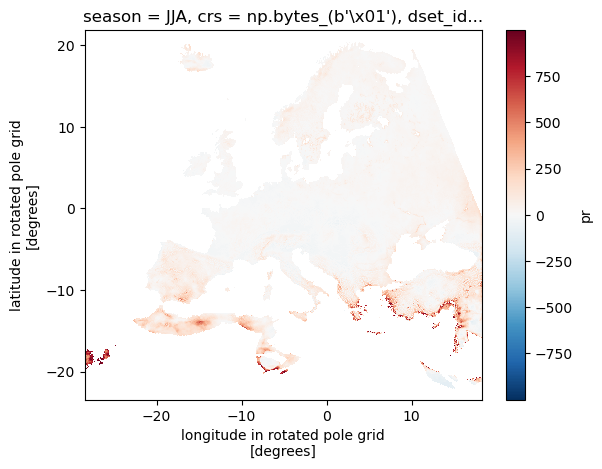

In [35]:
seasonal_bias["pr"].isel(season=1, dset_id=3).plot()

In [36]:
dset_id_regions = regional_means(seasonal_bias, regions, aggr=var_dic[index]["aggr"])
dset_id_regions.to_netcdf(
    f"{save_results_path}/{index}_{mip_era}_{reference_regions}_{period.start}-{period.stop}.nc"
)

## CMIP5 

In [37]:
mip_era = "CMIP5"
driving_source_id = "ERAINT"
# Define how to merge the files in xarray
# merge = ["variable_id", "frequency", "driving_variant_label", "version"]
# default_attrs = [d for d in default_attrs_ if d not in merge]

In [38]:
dsets = open_datasets(
    [variable],
    frequency=frequency,
    driving_source_id=driving_source_id,
    mask=True,
    add_missing_bounds=False,
)

Found: ['ALADIN53', 'ALADIN63', 'RACMO22E', 'RCA4', 'REMO2009', 'REMO2015'] for variables: ['pr']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.version'


decoding dataset CORDEX.EUR-11.GERICS.ERAINT.evaluation.r0i0p0.REMO2015.v1.fx.v20180813
Warning for CORDEX.EUR-11.GERICS.ERAINT.evaluation.r0i0p0.REMO2015.v1.fx.v20180813: Variable(s) referenced in cell_measures not in variables: ['areacella']
Found 12 datasets
decoding dataset CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN53.v1.fx.v20150127
Found 12 datasets
decoding dataset CORDEX.EUR-11.KNMI.ERAINT.evaluation.r1i1p1.RACMO22E.v1.fx.v20140218
Found 12 datasets
decoding dataset CORDEX.EUR-11.SMHI.ERAINT.evaluation.r1i1p1.RCA4.v1.mon.v20131026
Found 12 datasets
decoding dataset CORDEX.EUR-11.MPI-CSC.ERAINT.evaluation.r1i1p1.REMO2009.v1.mon.v20160525
Found 12 datasets
decoding dataset CORDEX.EUR-11.MPI-CSC.ERAINT.evaluation.r0i0p0.REMO2009.v1.fx.v20160525
Warning for CORDEX.EUR-11.MPI-CSC.ERAINT.evaluation.r0i0p0.REMO2009.v1.fx.v20160525: Variable(s) referenced in cell_measures not in variables: ['areacella']
Found 12 datasets
decoding dataset CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i

In [39]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

Temporal coverage of CORDEX.EUR-11.SMHI.ERAINT.evaluation.r1i1p1.RCA4.v1.mon.v20131026 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN53.v1.mon.v20150127 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX.EUR-11.GERICS.ERAINT.evaluation.r1i1p1.REMO2015.v1.mon.v20180813 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN63.v1.mon.v20191118 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX.EUR-11.KNMI.ERAINT.evaluation.r1i1p1.RACMO22E.v1.mon.v20140218 does not match with slice('1989', '2008', None)


In [40]:
for dset in dsets.keys():
    dsets[dset] = convert_celsius_to_kelvin(dsets[dset])

In [41]:
dsets = regrid_dsets(dsets, rotated_grid, method=regridding)

CORDEX.EUR-11.SMHI.ERAINT.evaluation.r1i1p1.RCA4.v1.mon.v20131026
CORDEX.EUR-11.MPI-CSC.ERAINT.evaluation.r1i1p1.REMO2009.v1.mon.v20160525
CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN53.v1.mon.v20150127
regridding CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN53.v1.mon.v20150127 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (453, 453) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
CORDEX.EUR-11.GERICS.ERAINT.evaluation.r1i1p1.REMO2015.v1.mon.v20180813
CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN63.v1.mon.v20191118
regridding CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN63.v1.mon.v20191118 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x424.nc 
Reuse pre-computed weights? 

In [42]:
if var_dic[index]["diff"] == "abs":
    diffs = {
        dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
        - (ref_seasmean + 273.15)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
elif var_dic[index]["diff"] == "rel":
    diffs = {
        dset_id: 100
        * (
            seasonal_mean(ds[[variable]].sel(time=period)).compute() * 86400
            - (ref_seasmean)
        )
        / (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }

seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(
            map(
                lambda x: short_iid(x, ["source_id"], delimiter="-"),
                diffs.keys(),
            )
        ),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 9.77 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [43]:
seasonal_bias[variable] = seasonal_bias[variable].where(
    (seasonal_bias[variable] <= 1000) & (seasonal_bias[variable] >= -1000)
)

In [44]:
dset_id_regions = regional_means(seasonal_bias, regions, aggr=var_dic[index]["aggr"])
dset_id_regions.to_netcdf(
    f"{save_results_path}/{index}_{mip_era}_{reference_regions}_{period.start}-{period.stop}.nc"
)

#### Load results for both CMIP5 and CMIP6 simulations

In [45]:
seasons = ["DJF", "MAM", "JJA", "SON"]

In [46]:
dset_id_regions_CMIP6 = xr.open_dataset(
    f"{save_results_path}/{index}_CMIP6_{reference_regions}_{period.start}-{period.stop}.nc"
)
dset_id_regions_CMIP5 = xr.open_dataset(
    f"{save_results_path}/{index}_CMIP5_{reference_regions}_{period.start}-{period.stop}.nc"
)

In [47]:
df_CMIP6 = dset_id_regions_CMIP6.to_dataframe().reset_index()
df_CMIP5 = dset_id_regions_CMIP5.to_dataframe().reset_index()

In [48]:
df_obs = obs_regions.to_dataframe().reset_index()

In [49]:
print(np.min(df_CMIP5[variable]), np.max(df_CMIP5[variable]))
print(np.min(df_CMIP6[variable]), np.max(df_CMIP6[variable]))

-18.248641298975244 167.05975137310625
-23.313006334721162 101.61783381072112


/tmp/ipykernel_1223123/956254315.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CMIP6_region["season_num"] = df_CMIP6_region["season"].apply(
/tmp/ipykernel_1223123/956254315.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CMIP5_region["season_num"] = df_CMIP5_region["season"].apply(
/tmp/ipykernel_1223123/956254315.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

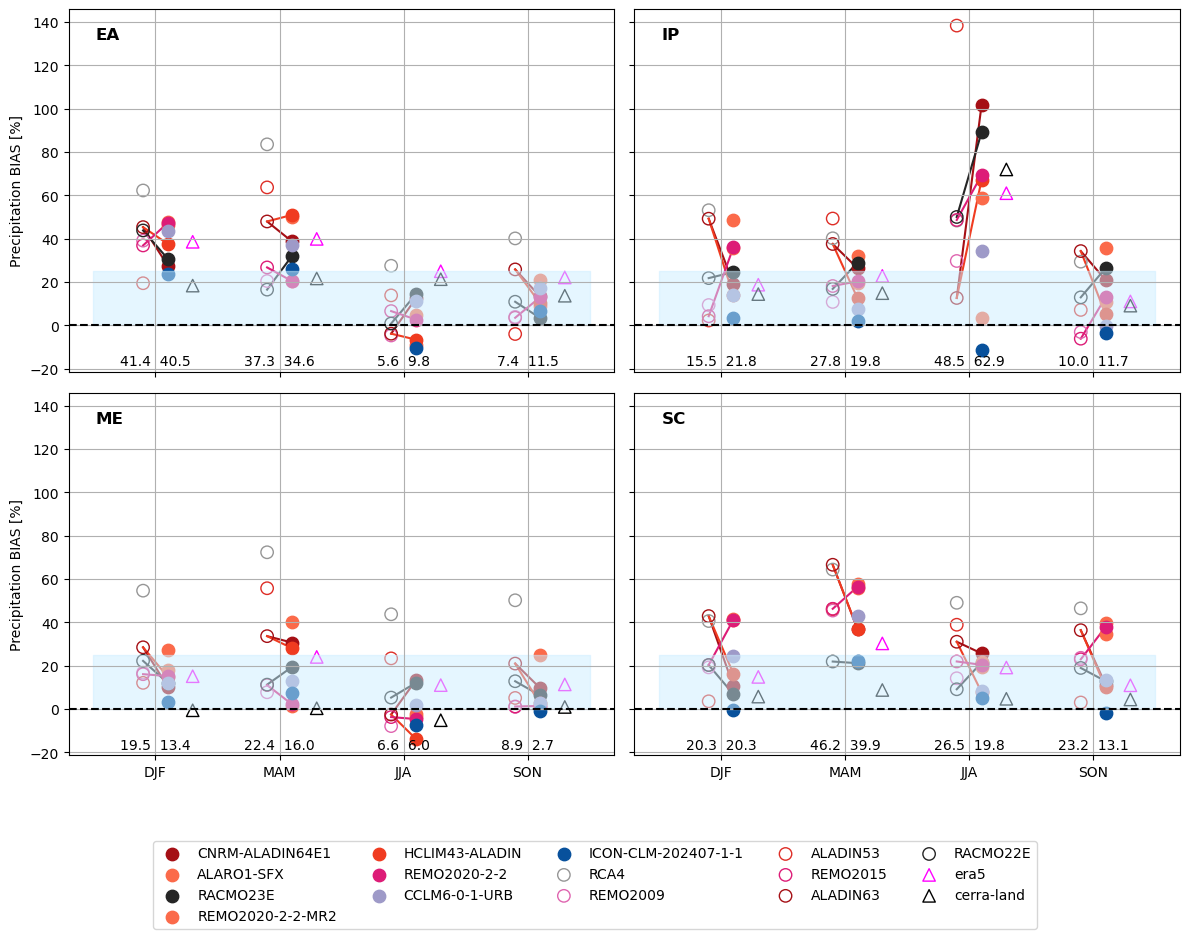

In [50]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

regs = ["EA", "IP", "ME", "SC"]
default_color = "#fb6a4a"

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

handles = []
labels = []

for i, region in enumerate(regs):
    ax = axes[i]

    df_CMIP6_region = df_CMIP6[df_CMIP6["abbrevs"] == region]
    df_CMIP5_region = df_CMIP5[df_CMIP5["abbrevs"] == region]
    df_obs_region = df_obs[df_obs["abbrevs"] == region]

    df_CMIP6_region["season_num"] = df_CMIP6_region["season"].apply(
        lambda x: seasons.index(x)
    )
    df_CMIP5_region["season_num"] = df_CMIP5_region["season"].apply(
        lambda x: seasons.index(x)
    )
    df_obs_region["season_num"] = df_obs_region["season"].apply(
        lambda x: seasons.index(x)
    )

    df_CMIP6_region["season_shifted"] = df_CMIP6_region["season_num"] + 0.1
    df_CMIP5_region["season_shifted"] = df_CMIP5_region["season_num"] - 0.1
    df_obs_region["season_shifted"] = df_obs_region["season_num"] + 0.3

    # Create lists to store the bias values for calculating median
    cmip6_biases = {season: [] for season in seasons}
    cmip5_biases = {season: [] for season in seasons}

    for idx, row in df_CMIP6_region.iterrows():
        dset_id = row["dset_id"]
        dset_id_in_table = dset_id in eur_colors.model.values
        color = (
            eur_colors[eur_colors["model"] == dset_id].color.values[0]
            if dset_id_in_table
            else default_color
        )
        parent = (
            eur_colors[eur_colors["model"] == dset_id].parent.values[0]
            if dset_id_in_table
            else None
        )

        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            marker="o",
            s=80,
        )

        # Collect bias values for median calculation
        cmip6_biases[row["season"]].append(abs(row[variable]))

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

        if parent is not None:
            row_cmip5 = df_CMIP5_region[df_CMIP5_region["dset_id"] == parent]
            if not row_cmip5.empty:
                row_cmip5 = row_cmip5[row_cmip5["season"] == row.season].iloc[0]
                ax.plot(
                    [row_cmip5["season_shifted"], row["season_shifted"]],
                    [row_cmip5[variable], row[variable]],
                    color=color,
                    linestyle="-",
                    zorder=0,
                )

    for idx, row in df_CMIP5_region.iterrows():
        dset_id = row["dset_id"]
        dset_id_in_table = dset_id in eur_colors.model.values
        color = (
            eur_colors[eur_colors["model"] == dset_id].color.values[0]
            if dset_id_in_table
            else default_color
        )

        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor="none",
            marker="o",
            s=80,
        )

        # Collect bias values for median calculation
        cmip5_biases[row["season"]].append(abs(row[variable]))

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    for idx, row in df_obs_region.iterrows():
        dset_id = row["dset_id"]
        if "era5" in dset_id:
            color = "magenta"
        else:
            color = "black"
        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor="none",
            marker="^",
            s=80,
        )

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    axes[0].set_ylabel(var_dic[index]["name"])
    axes[2].set_ylabel(var_dic[index]["name"])
    # Add region label in the top-left corner of each subplot
    ax.text(
        0.05,
        0.95,
        region,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="left",
        color="black",
        weight="bold",
    )

    ax.set_xticks([0, 1, 2, 3])  # Adjust tick positions according to the shift
    ax.set_xticklabels(seasons)  # Set the names of the seasons as labels

    ax.grid(True)
    ax.axhline(0, color="black", linestyle="--")

    if index == "pr":
        ax.fill_between([-0.5, 3.5], 0, 25, color="#cceeff", alpha=0.5)

    # Calculate and display the absolute median bias for each season for both CMIP5 and CMIP6
    for j, season in enumerate(seasons):
        cmip6_median = (
            np.nanmedian(cmip6_biases[season]) if cmip6_biases[season] else np.nan
        )
        cmip5_median = (
            np.nanmedian(cmip5_biases[season]) if cmip5_biases[season] else np.nan
        )

        # Add the absolute median bias text below the season labels
        ax.text(
            j,
            0.01,  # x in data coords, y as fraction of axes height (just above bottom)
            f"{cmip5_median:.1f}  {cmip6_median:.1f}",
            fontsize=10,
            verticalalignment="bottom",
            horizontalalignment="center",
            color="black",
            transform=ax.get_xaxis_transform(),  # y in axes coords, x in data coords
        )
#        ax.text(j, var_dic[index]['range'][0]+0.5, f'{cmip5_median:.1f}  {cmip6_median:.1f}',
#                fontsize=10, verticalalignment='top', horizontalalignment='center', color='black')

fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=5,
    fontsize=10,
)


plt.tight_layout()
plt.show()
fig.savefig(
    f"{save_figure_path}/{reference_regions}_A_bias_{index}_{period.start}-{period.stop}.png",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
)

/tmp/ipykernel_1223123/4084025434.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CMIP6_region["season_num"] = df_CMIP6_region["season"].apply(
/tmp/ipykernel_1223123/4084025434.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CMIP5_region["season_num"] = df_CMIP5_region["season"].apply(
/tmp/ipykernel_1223123/4084025434.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

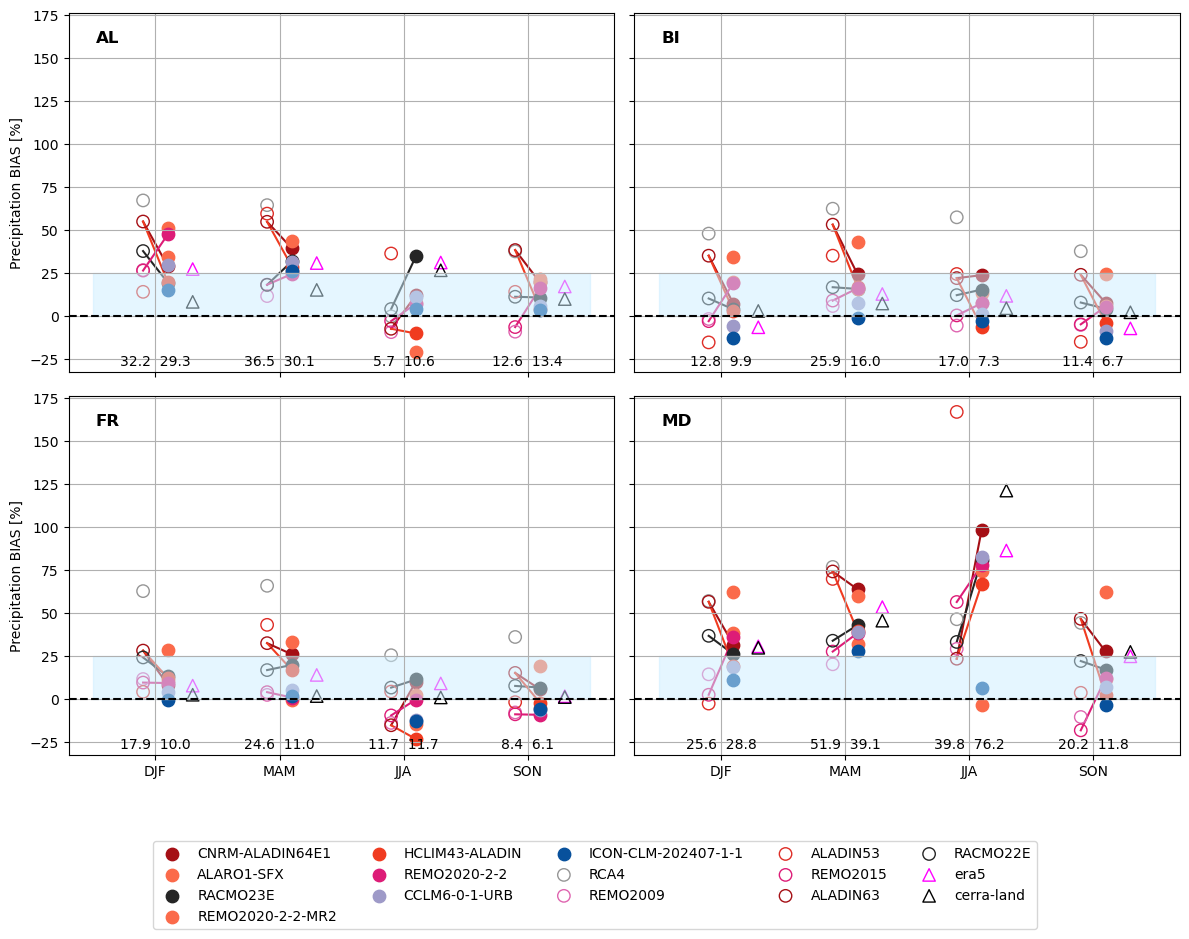

In [51]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

regs = ["AL", "BI", "FR", "MD"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

handles = []
labels = []

for i, region in enumerate(regs):
    ax = axes[i]

    df_CMIP6_region = df_CMIP6[df_CMIP6["abbrevs"] == region]
    df_CMIP5_region = df_CMIP5[df_CMIP5["abbrevs"] == region]
    df_obs_region = df_obs[df_obs["abbrevs"] == region]

    df_CMIP6_region["season_num"] = df_CMIP6_region["season"].apply(
        lambda x: seasons.index(x)
    )
    df_CMIP5_region["season_num"] = df_CMIP5_region["season"].apply(
        lambda x: seasons.index(x)
    )
    df_obs_region["season_num"] = df_obs_region["season"].apply(
        lambda x: seasons.index(x)
    )

    df_CMIP6_region["season_shifted"] = df_CMIP6_region["season_num"] + 0.1
    df_CMIP5_region["season_shifted"] = df_CMIP5_region["season_num"] - 0.1
    df_obs_region["season_shifted"] = df_obs_region["season_num"] + 0.3

    # Create lists to store the bias values for calculating median
    cmip6_biases = {season: [] for season in seasons}
    cmip5_biases = {season: [] for season in seasons}

    for idx, row in df_CMIP6_region.iterrows():
        dset_id = row["dset_id"]
        dset_id_in_table = dset_id in eur_colors.model.values
        color = (
            eur_colors[eur_colors["model"] == dset_id].color.values[0]
            if dset_id_in_table
            else default_color
        )
        parent = (
            eur_colors[eur_colors["model"] == dset_id].parent.values[0]
            if dset_id_in_table
            else None
        )

        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            marker="o",
            s=80,
        )

        # Collect bias values for median calculation
        cmip6_biases[row["season"]].append(abs(row[variable]))

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

        if parent is not None:
            row_cmip5 = df_CMIP5_region[df_CMIP5_region["dset_id"] == parent]
            if not row_cmip5.empty:
                row_cmip5 = row_cmip5[row_cmip5["season"] == row.season].iloc[0]
                ax.plot(
                    [row_cmip5["season_shifted"], row["season_shifted"]],
                    [row_cmip5[variable], row[variable]],
                    color=color,
                    linestyle="-",
                    zorder=0,
                )

    for idx, row in df_CMIP5_region.iterrows():
        dset_id = row["dset_id"]
        dset_id_in_table = dset_id in eur_colors.model.values
        color = (
            eur_colors[eur_colors["model"] == dset_id].color.values[0]
            if dset_id_in_table
            else default_color
        )
        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor="none",
            marker="o",
            s=80,
        )

        # Collect bias values for median calculation
        cmip5_biases[row["season"]].append(abs(row[variable]))

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    for idx, row in df_obs_region.iterrows():
        dset_id = row["dset_id"]
        if "era5" in dset_id:
            color = "magenta"
        else:
            color = "black"
        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor="none",
            marker="^",
            s=80,
        )

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    axes[0].set_ylabel(var_dic[index]["name"])
    axes[2].set_ylabel(var_dic[index]["name"])
    # Add region label in the top-left corner of each subplot
    ax.text(
        0.05,
        0.95,
        region,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="left",
        color="black",
        weight="bold",
    )

    ax.set_xticks([0, 1, 2, 3])  # Adjust tick positions according to the shift
    ax.set_xticklabels(seasons)  # Set the names of the seasons as labels

    ax.grid(True)
    ax.axhline(0, color="black", linestyle="--")

    if index == "pr":
        ax.fill_between([-0.5, 3.5], 0, 25, color="#cceeff", alpha=0.5)

    # Calculate and display the absolute median bias for each season for both CMIP5 and CMIP6
    for j, season in enumerate(seasons):
        cmip6_median = (
            np.nanmedian(cmip6_biases[season]) if cmip6_biases[season] else np.nan
        )
        cmip5_median = (
            np.nanmedian(cmip5_biases[season]) if cmip5_biases[season] else np.nan
        )

        # Add the absolute median bias text below the season labels
        ax.text(
            j,
            0.01,  # x in data coords, y as fraction of axes height (just above bottom)
            f"{cmip5_median:.1f}  {cmip6_median:.1f}",
            fontsize=10,
            verticalalignment="bottom",
            horizontalalignment="center",
            color="black",
            transform=ax.get_xaxis_transform(),  # y in axes coords, x in data coords
        )
#        ax.text(j, var_dic[index]['range'][0]+0.5, f'{cmip5_median:.1f}  {cmip6_median:.1f}',
#                fontsize=10, verticalalignment='top', horizontalalignment='center', color='black')

fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=5,
    fontsize=10,
)


plt.tight_layout()
plt.show()
fig.savefig(
    f"{save_figure_path}/{reference_regions}_B_bias_{index}_{period.start}-{period.stop}.png",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
)